# Regresión losgística para análisis de sentimientos

En este notebook se va a estudiar el modelo de Regresión Logística aplicado a análisis de sentimientos.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import torch
from utils import *

import matplotlib.pyplot as plt
%matplotlib notebook
                
%load_ext autoreload
%autoreload 2

## Problema general

Vamos a formular el problema de análisis de sentimientos como un problema de clasificación binaria. Se dispondrá de un conjunto de datos de entrenamiento que consisten en una serie de comentarios conformados por una secuencia de palabras, y su respectiva connotación (positiva o negativa). El objetivo de esta parte será estudiar el modelo de **regresión logística** utilizado para resolver este problema.

Antes de continuar, detallamos la notación que vamos a utilizar:

* El texto de entrada va a ser mapeado a un ejemplo de un vector aleatorio $\mathbf{x}=\begin{bmatrix} x_1 & x_2 & \ldots & x_n \end{bmatrix}^T$ que representa el conjunto de features de ese texto.

* La clase a la que pertenece cada comentario se denota con un ejemplo de una variable aleatoria $y$, con realizaciones en el conjunto $\{ 0,1 \}$. De esta manera, hacemos corresponder a $y=1$ cuando el texto tiene una connotación positiva y a $y=0$ cuando ésta es negativa.

* El conjunto de $N$ muestras de entrenamiento se representa por $\left\{ \left(\mathbf{x}^{(i)}, y^{(i)}\right) \right\}_{i=1}^N$.

## El modelo

El modelo de regresión logística es un modelo discriminativo que forma parte de la familia de modelos discriminativos paramétricos conocida como **Modelos Lineales Generalizados** (*Generalized Linear Models*, GLM). Un modelo de este tipo puede construirse de la siguiente manera:

1. Se define que la variable aleatoria $y|\mathbf{x}$ que relaciona la entrada con la salida depende de un conjunto de parámetros $\theta$ y pertenece a la familia de exponenciales de parámetro $\eta$ de tal manera que $\eta = \theta^T \mathbf{x}$. Esto es:

$$
\begin{align*}
y|\mathbf{x} &\sim \mathrm{ExpFamily}\left(\eta\right) \\[.5em]
P(y|\mathbf{x}) &= b(y)\exp\left( \eta^T y - a\left(\eta\right)\right) \\[.5em]
P(y|\mathbf{x};\theta) &= b(y)\exp\left( \mathbf{x}^T \theta y - a(\theta^T \mathbf{x})\right)
\end{align*}
$$

2. La salida del modelo se obtiene por medio de

$$
h_\theta(\mathbf{x}) = E\left[ y|\mathbf{x}\right]
$$

El modelo de regresión logistica consiste en definir la probabilidad a posteriori 

$$
P(y|\mathbf{x};\theta) = \sigma\left( \theta^T \mathbf{x} \right)^y \left( 1 - \sigma\left( \theta^T \mathbf{x} \right) \right)^{(1-y)}
$$

donde 

$$
\sigma(z) = \frac{1}{1+ e^{-z}}
$$ 

y puede mostrarse que forma parte de los modelos GLM para el caso en que $T(y)=y$, $b(y)=1$ y $a(\theta^T\mathbf{x})=\log\left(1+e^{\theta^T\mathbf{x}}\right)$. 

También puede verse que 

$$
h_\theta(\mathbf{x}) = E\left[ y|\mathbf{x}\right] = P(y=1|\mathbf{x};\theta)\cdot 1 + P(y=0|\mathbf{x};\theta)\cdot 0 = \sigma\left( \theta^T \mathbf{x} \right)
$$

por lo que la salida del modelo da la probabilidad de pertenecer a la clase $y=1$, y por lo tanto, aporta todo lo necesario para realizar una nueva predicción.

En lo que sigue, adoptaremos el criterio de **máxima verosimilitud** para estimar los parámetros del modelo. De esta forma:

$$
\begin{align*}
\hat{\theta} &= \mathrm{argmax}_\theta \prod_{i=1}^N P\left(y^{(i)}|\mathbf{x}^{(i)};\theta\right) \\
&= \mathrm{argmax}_\theta \prod_{i=1}^N \sigma\left( \theta^T \mathbf{x}^{(i)} \right)^{y^{(i)}} \left( 1 - \sigma\left( \theta^T \mathbf{x}^{(i)} \right) \right)^{(1-y^{(i)})}\\
&= \mathrm{argmax}_\theta \log\left(\prod_{i=1}^N \sigma\left( \theta^T \mathbf{x}^{(i)} \right)^{y^{(i)}} \left( 1 - \sigma\left( \theta^T \mathbf{x}^{(i)} \right) \right)^{(1-y^{(i)})}\right)\\
&= \mathrm{argmax}_\theta \sum_{i=1}^N y^{(i)} \log\left(\sigma\left( \theta^T \mathbf{x}^{(i)} \right)\right) + \left(1 - y^{(i)}\right) \log\left(1 - \sigma\left( \theta^T \mathbf{x}^{(i)} \right)\right)\\
\end{align*}
$$

## Extracción de features

Si bien extraer características es el principal problema en procesamiento de lenguaje, en este caso sólo se experimentará con una serie de variantes en la tarea de representar un texto como una serie de características o *features*. Sin embargo, la parte en la que se comprende lo que se está diciendo en el texto está incluída, sin duda, en la extracción de features del texto. 

### Bolsa de Palabras

Una forma muy común de representar un texto es con una **Bolsa de Palabras** (*Bag of Words*, BOW). Este método consiste en definir un vocabulario de palabras $V=\{ w_1, w_2,\ldots, w_n\}$ y contar la cantidad de veces que apareció cada una de estas palabras en el texto. De esta manera, la $i$-ésima coordenada del vector $\mathbf{x}$ corresponde a la cantidad de veces que apareció la palabra $w_i$ en el texto.

Por ejemplo, supongamos que se tiene el siguiente texto:

```
<START> I am Sam. Sam I am. I do not like green eggs and ham. <END>
```

y se define un vocabulario `V = ['I', 'am', 'Sam', 'do', 'not', 'like', 'green', 'eggs', 'and', 'ham', '.', '<START>', '<END>']`. Entonces, el vector de features que representa el texto anterior es

$$
x = \begin{bmatrix}
count(I) \\
count(am) \\
count(Sam) \\
\vdots \\
count(.) \\
count(<START>) \\
count(<END>) 
\end{bmatrix}
=
\begin{bmatrix}
3 \\ 2 \\ 2 \\ \vdots \\ 3 \\ 1 \\ 1 
\end{bmatrix}
$$

Notemos varias cosas:

* Esta representación es equivalente a representar un histograma de las palabras de que aparecen en cada muestra.

* No se tiene en cuenta el orden en el que aparecen las palabras, por lo que se está perdiendo información (¡y muy valiosa!)

* Existen elementos del vocabulario, como el punto y los signos de comienzo y fin del texto, que no son palabras pero que, sin embargo, forma parte del texto. Esto se hace porque aportan información valiosa sobre el texto, y descartarlos, muchas veces disminuye el desempeño del algoritmo. Por otro lado, se verá que tener muchos componentes en el vocabulario también puede jugar en contra de la cantidad de aciertos. Es común denominar a los integrantes del vocabulario ***tokens*** cuando se refiere a los ejemplos de estos elementos en el texto, y ***types*** cuando se refieren a los elementos en sí.

* Existe la posibilidad de que en el texto aparezcan tokens (como por ejemplo `green`) que no forman parte del vocabulario. En este caso se suelen ignorar estas apariciones, aunque a veces se suele incorporar un token especial de tipo desconocido (representado como `<UNK>`) que contabilice las palabras que están fuera del vocabulario. 

# Implementación

Obtenemos las muestras

In [2]:
# Leemos y separamos en train / dev / test:
df_train, df_dev, df_test, vocab = read_and_split_dataset()
idx_to_tk = {idx: tk for idx, tk in enumerate(vocab)}
vocab_size = len(vocab)

# Tokenizamos:
samples = {}
unk_tk = '<UNK>'
unk_idx = vocab_size
for data, df in zip(['train', 'dev'],[df_train, df_dev]):
    samples[data] = tokenize_dataframe(df, vocab, unk_idx)

Definimos el dataset y el batch

In [3]:
from torch.utils.data import Dataset, DataLoader

class IMDbBOWDataset(Dataset):
    
    def __init__(self, samples, vocab_size):
        
        num_samples = len(samples)
        self.x = torch.zeros(num_samples,vocab_size, dtype=torch.float)
        for i, sample in enumerate(samples):
            for j in sample[0]:
                if j!= vocab_size:
                    self.x[i,j] += 1.
            
        self.y = torch.tensor([sample[1] for sample in samples], dtype=torch.float).view(-1,1)
        
    def __getitem__(self,idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return len(self.y)
    
padding_idx = vocab_size
train_dataset = IMDbBOWDataset(samples['train'],padding_idx)
dev_dataset = IMDbBOWDataset(samples['dev'], padding_idx)

In [4]:
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size, shuffle=True)

Definimos el modelo

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class LogisticRegression(nn.Module):
    
    def __init__(self,vocab_size):
        super().__init__()
        self.linear = nn.Linear(vocab_size,1)
        
    def forward(self,x):
        return self.linear(x)
    

model = LogisticRegression(vocab_size)
device = 'cuda:1'
LRTrainer = Trainer(train_loader,dev_loader,model,device)

Entrenamiento:

In [40]:
# Configuración del entrenamiento:
loss_fn = 'BCE'
optim_algorithm = 'Adam'
epochs = 100
sample_loss_every = 20
check_on_train = True
learning_rate = 1e-4

LRTrainer.train(loss_fn,optim_algorithm,epochs,sample_loss_every,check_on_train,lr=learning_rate)

Resuming training...
Loss function: BCE
Optimization method: Adam
Learning Rate: 0.0001
Number of epochs: 100
Running on device (cuda:1)

Epoch: 1, Batch number: 0, Loss: 0.12122833728790283
Accuracy on validation dataset: 2541/5000 (50.82%)
Accuracy on training dataset: 10008/20000 (50.04%)

Epoch: 1, Batch number: 20, Loss: 0.1729176640510559
Accuracy on validation dataset: 2540/5000 (50.80%)
Accuracy on training dataset: 10025/20000 (50.12%)

Epoch: 2, Batch number: 0, Loss: -0.12073114514350891
Accuracy on validation dataset: 2544/5000 (50.88%)
Accuracy on training dataset: 10040/20000 (50.20%)

Epoch: 2, Batch number: 20, Loss: -0.5830476880073547
Accuracy on validation dataset: 2545/5000 (50.90%)
Accuracy on training dataset: 10048/20000 (50.24%)

Epoch: 3, Batch number: 0, Loss: -0.5701159834861755
Accuracy on validation dataset: 2545/5000 (50.90%)
Accuracy on training dataset: 10055/20000 (50.27%)

Epoch: 3, Batch number: 20, Loss: 0.6103765964508057
Accuracy on validation data

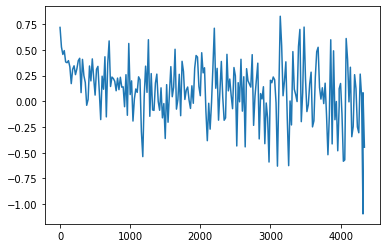

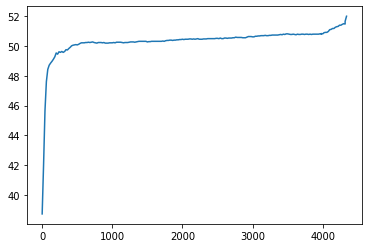

In [48]:
LRTrainer.plot_history()

Me dio underfitting. Vamos a agregarle un layer intermedio.

In [10]:
class TwoLayerNet(nn.Module):
    
    def __init__(self,vocab_size,h_dim):
        super().__init__()
        self.linear1 = nn.Linear(vocab_size,h_dim)
        self.linear2 = nn.Linear(h_dim,1)
        
    def forward(self,x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x
    

h_dim = 1000
model2 = TwoLayerNet(vocab_size,h_dim)
device = 'cuda:1'
TwoLayerNetTrainer = Trainer(train_loader,dev_loader,model2,device)

In [11]:
# Configuración del entrenamiento:
loss_fn = 'BCE'
optim_algorithm = 'Adam'
epochs = 100
sample_loss_every = 20
check_on_train = True
learning_rate = 1e-4

TwoLayerNetTrainer.train(loss_fn,optim_algorithm,epochs,sample_loss_every,check_on_train,lr=learning_rate)

Starting training...
Loss function: BCE
Optimization method: Adam
Learning Rate: 0.0001
Number of epochs: 100
Running on device (cuda:1)

Epoch: 1, Batch number: 0, Loss: 0.6930274963378906
Accuracy on validation dataset: 1949/5000 (38.98%)
Accuracy on training dataset: 7979/20000 (39.90%)

Epoch: 2, Batch number: 0, Loss: 0.25974240899086
Accuracy on validation dataset: 2528/5000 (50.56%)
Accuracy on training dataset: 9998/20000 (49.99%)

Epoch: 3, Batch number: 0, Loss: 0.2372168004512787
Accuracy on validation dataset: 2538/5000 (50.76%)
Accuracy on training dataset: 10014/20000 (50.07%)

Epoch: 4, Batch number: 0, Loss: -0.6233561635017395
Accuracy on validation dataset: 2565/5000 (51.30%)
Accuracy on training dataset: 10101/20000 (50.51%)

Epoch: 5, Batch number: 0, Loss: -0.12244324386119843
Accuracy on validation dataset: 2630/5000 (52.60%)
Accuracy on training dataset: 10429/20000 (52.15%)

Epoch: 6, Batch number: 0, Loss: -1.1425628662109375
Accuracy on validation dataset: 272

Accuracy on training dataset: 11429/20000 (57.15%)

Epoch: 53, Batch number: 0, Loss: -139.82244873046875
Accuracy on validation dataset: 2873/5000 (57.46%)
Accuracy on training dataset: 11450/20000 (57.25%)

Epoch: 54, Batch number: 0, Loss: -128.30020141601562
Accuracy on validation dataset: 2875/5000 (57.50%)
Accuracy on training dataset: 11505/20000 (57.52%)

Epoch: 55, Batch number: 0, Loss: -111.06503295898438
Accuracy on validation dataset: 2874/5000 (57.48%)
Accuracy on training dataset: 11473/20000 (57.37%)

Epoch: 56, Batch number: 0, Loss: -168.22274780273438
Accuracy on validation dataset: 2875/5000 (57.50%)
Accuracy on training dataset: 11489/20000 (57.45%)

Epoch: 57, Batch number: 0, Loss: -206.28118896484375
Accuracy on validation dataset: 2871/5000 (57.42%)
Accuracy on training dataset: 11410/20000 (57.05%)

Epoch: 58, Batch number: 0, Loss: -168.37181091308594
Accuracy on validation dataset: 2875/5000 (57.50%)
Accuracy on training dataset: 11501/20000 (57.51%)

Epoch:

Un layer intermedio no se puede hacer porque son muchos parámetros. Vamos a reducir el vocabulario

In [2]:
# Leemos y separamos en train / dev / test:
df_train, df_dev, df_test, vocab = read_and_split_dataset()
idx_to_tk = {idx: tk for idx, tk in enumerate(vocab)}


# Nos quedamos con las palabras más frecuentes:

import nltk
df = df_train
df = df.copy()
df['comment'] = df['comment'].str.lower().apply(nltk.tokenize.word_tokenize,args=('english', False))

tk_to_freq = {tk: 0 for tk in vocab}
for comment in df['comment']:
    for tk in comment:
        try:
            tk_to_freq[tk] += 1
        except KeyError:
            continue
            
freqs = np.array(list(tk_to_freq.values()))
arg_freqs = np.argsort(freqs)[::-1]
vocab = [vocab[i] for i in arg_freqs[:10000]]
vocab_size = len(vocab)

In [3]:
# Tokenizamos:
samples = {}
unk_tk = '<UNK>'
unk_idx = vocab_size
for data, df in zip(['train', 'dev'],[df_train, df_dev]):
    samples[data] = tokenize_dataframe(df, vocab, unk_idx)

In [4]:
from torch.utils.data import Dataset, DataLoader

class IMDbBOWDataset(Dataset):
    
    def __init__(self, samples, vocab_size):
        
        num_samples = len(samples)
        self.x = torch.zeros(num_samples,vocab_size, dtype=torch.float)
        for i, sample in enumerate(samples):
            for j in sample[0]:
                if j!= vocab_size:
                    self.x[i,j] += 1.
            
        self.y = torch.tensor([sample[1] for sample in samples], dtype=torch.float).view(-1,1)
        
    def __getitem__(self,idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return len(self.y)
    
padding_idx = vocab_size
train_dataset = IMDbBOWDataset(samples['train'],padding_idx)
dev_dataset = IMDbBOWDataset(samples['dev'], padding_idx)

In [27]:
from classifiers import *

classifier = LogisticRegressionClassifier(vocab_size,bias=True,device='cuda:1')

In [28]:
classifier.train(train_dataset, optim_algorithm='Adam',
                 epochs=1000, batch_size=2048, lr=.01)

Starting training...
Epoch 1 finished. Approximate loss: 0.0974
Epoch 2 finished. Approximate loss: -0.6364
Epoch 3 finished. Approximate loss: -1.0847
Epoch 4 finished. Approximate loss: -1.8165
Epoch 5 finished. Approximate loss: -1.9596
Epoch 6 finished. Approximate loss: -2.7733
Epoch 7 finished. Approximate loss: -3.0011
Epoch 8 finished. Approximate loss: -3.7192
Epoch 9 finished. Approximate loss: -4.5293
Epoch 10 finished. Approximate loss: -4.9631
Epoch 11 finished. Approximate loss: -5.3402
Epoch 12 finished. Approximate loss: -5.4280
Epoch 13 finished. Approximate loss: -6.4952
Epoch 14 finished. Approximate loss: -7.9116
Epoch 15 finished. Approximate loss: -8.2333
Epoch 16 finished. Approximate loss: -8.5309
Epoch 17 finished. Approximate loss: -8.5437
Epoch 18 finished. Approximate loss: -9.4093
Epoch 19 finished. Approximate loss: -9.2783
Epoch 20 finished. Approximate loss: -10.1181
Epoch 21 finished. Approximate loss: -10.8163
Epoch 22 finished. Approximate loss: -11.3

Epoch 178 finished. Approximate loss: -105.1836
Epoch 179 finished. Approximate loss: -114.4433
Epoch 180 finished. Approximate loss: -100.4671
Epoch 181 finished. Approximate loss: -103.6795
Epoch 182 finished. Approximate loss: -105.2397
Epoch 183 finished. Approximate loss: -116.8301
Epoch 184 finished. Approximate loss: -108.0475
Epoch 185 finished. Approximate loss: -100.0250
Epoch 186 finished. Approximate loss: -119.1226
Epoch 187 finished. Approximate loss: -119.4275
Epoch 188 finished. Approximate loss: -112.6976
Epoch 189 finished. Approximate loss: -121.9364
Epoch 190 finished. Approximate loss: -119.0801
Epoch 191 finished. Approximate loss: -117.9372
Epoch 192 finished. Approximate loss: -113.4332
Epoch 193 finished. Approximate loss: -111.1450
Epoch 194 finished. Approximate loss: -118.8548
Epoch 195 finished. Approximate loss: -116.2715
Epoch 196 finished. Approximate loss: -115.3569
Epoch 197 finished. Approximate loss: -117.2007
Epoch 198 finished. Approximate loss: -1

Epoch 349 finished. Approximate loss: -175.6995
Epoch 350 finished. Approximate loss: -212.4259
Epoch 351 finished. Approximate loss: -199.5140
Epoch 352 finished. Approximate loss: -207.6127
Epoch 353 finished. Approximate loss: -213.5981
Epoch 354 finished. Approximate loss: -230.8863
Epoch 355 finished. Approximate loss: -216.0765
Epoch 356 finished. Approximate loss: -232.8093
Epoch 357 finished. Approximate loss: -210.8007
Epoch 358 finished. Approximate loss: -213.3401
Epoch 359 finished. Approximate loss: -231.3944
Epoch 360 finished. Approximate loss: -196.0487
Epoch 361 finished. Approximate loss: -210.5972
Epoch 362 finished. Approximate loss: -233.0009
Epoch 363 finished. Approximate loss: -257.1661
Epoch 364 finished. Approximate loss: -191.1000
Epoch 365 finished. Approximate loss: -206.1449
Epoch 366 finished. Approximate loss: -201.2202
Epoch 367 finished. Approximate loss: -227.2124
Epoch 368 finished. Approximate loss: -212.2109
Epoch 369 finished. Approximate loss: -2

Epoch 520 finished. Approximate loss: -288.4724
Epoch 521 finished. Approximate loss: -321.6734
Epoch 522 finished. Approximate loss: -329.3170
Epoch 523 finished. Approximate loss: -313.9495
Epoch 524 finished. Approximate loss: -298.9719
Epoch 525 finished. Approximate loss: -283.8829
Epoch 526 finished. Approximate loss: -397.4103
Epoch 527 finished. Approximate loss: -304.1426
Epoch 528 finished. Approximate loss: -336.0091
Epoch 529 finished. Approximate loss: -329.0070
Epoch 530 finished. Approximate loss: -332.3178
Epoch 531 finished. Approximate loss: -286.8459
Epoch 532 finished. Approximate loss: -292.0172
Epoch 533 finished. Approximate loss: -302.5944
Epoch 534 finished. Approximate loss: -332.1918
Epoch 535 finished. Approximate loss: -333.0146
Epoch 536 finished. Approximate loss: -321.9497
Epoch 537 finished. Approximate loss: -279.1184
Epoch 538 finished. Approximate loss: -331.7827
Epoch 539 finished. Approximate loss: -310.3246
Epoch 540 finished. Approximate loss: -3

Epoch 691 finished. Approximate loss: -451.8960
Epoch 692 finished. Approximate loss: -415.6849
Epoch 693 finished. Approximate loss: -424.2487
Epoch 694 finished. Approximate loss: -386.4717
Epoch 695 finished. Approximate loss: -384.0064
Epoch 696 finished. Approximate loss: -399.5861
Epoch 697 finished. Approximate loss: -388.1553
Epoch 698 finished. Approximate loss: -420.6832
Epoch 699 finished. Approximate loss: -418.4183
Epoch 700 finished. Approximate loss: -338.3044
Epoch 701 finished. Approximate loss: -385.1776
Epoch 702 finished. Approximate loss: -499.0565
Epoch 703 finished. Approximate loss: -406.5690
Epoch 704 finished. Approximate loss: -437.4010
Epoch 705 finished. Approximate loss: -406.5791
Epoch 706 finished. Approximate loss: -437.1051
Epoch 707 finished. Approximate loss: -401.7551
Epoch 708 finished. Approximate loss: -472.1497
Epoch 709 finished. Approximate loss: -448.5664
Epoch 710 finished. Approximate loss: -413.1811
Epoch 711 finished. Approximate loss: -4

Epoch 862 finished. Approximate loss: -540.5111
Epoch 863 finished. Approximate loss: -503.1412
Epoch 864 finished. Approximate loss: -500.5101
Epoch 865 finished. Approximate loss: -531.5670
Epoch 866 finished. Approximate loss: -424.2885
Epoch 867 finished. Approximate loss: -485.3376
Epoch 868 finished. Approximate loss: -534.4977
Epoch 869 finished. Approximate loss: -516.0002
Epoch 870 finished. Approximate loss: -501.2491
Epoch 871 finished. Approximate loss: -562.4482
Epoch 872 finished. Approximate loss: -519.5982
Epoch 873 finished. Approximate loss: -540.5998
Epoch 874 finished. Approximate loss: -540.6643
Epoch 875 finished. Approximate loss: -512.7111
Epoch 876 finished. Approximate loss: -591.4170
Epoch 877 finished. Approximate loss: -499.3108
Epoch 878 finished. Approximate loss: -495.0967
Epoch 879 finished. Approximate loss: -570.4924
Epoch 880 finished. Approximate loss: -545.2364
Epoch 881 finished. Approximate loss: -488.5263
Epoch 882 finished. Approximate loss: -4

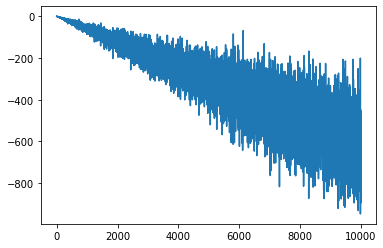

In [29]:
plt.plot(classifier.loss_history)

In [31]:
classifier.predict(dev_dataset)

Total accuracy: 2791/5000 (55.82%)


In [6]:
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size, shuffle=True)

In [44]:
import torch.nn as nn
import torch.nn.functional as F

class LogisticRegression(nn.Module):
    
    def __init__(self,vocab_size):
        super().__init__()
        self.linear = nn.Linear(vocab_size,1)
        
    def forward(self,x):
        return self.linear(x)
    

model = LogisticRegression(vocab_size)
device = 'cuda:1'
LRTrainer = Trainer(train_loader,dev_loader,model,device)

In [45]:
# Configuración del entrenamiento:
loss_fn = 'BCE'
optim_algorithm = 'Adam'
epochs = 100
sample_loss_every = 20
check_on_train = True
learning_rate = 1e-3

LRTrainer.train(loss_fn,optim_algorithm,epochs,sample_loss_every,check_on_train,lr=learning_rate)

Starting training...
Loss function: BCE
Optimization method: Adam
Learning Rate: 0.001
Number of epochs: 100
Running on device (cuda:1)

Epoch: 1, Batch number: 0, Loss: 0.7051641941070557
Accuracy on validation dataset: 1982/5000 (39.64%)
Accuracy on training dataset: 8092/20000 (40.46%)

Epoch: 2, Batch number: 0, Loss: 0.2502511739730835
Accuracy on validation dataset: 2521/5000 (50.42%)
Accuracy on training dataset: 9989/20000 (49.95%)

Epoch: 3, Batch number: 0, Loss: 0.07242456078529358
Accuracy on validation dataset: 2539/5000 (50.78%)
Accuracy on training dataset: 10010/20000 (50.05%)

Epoch: 4, Batch number: 0, Loss: 0.21413671970367432
Accuracy on validation dataset: 2563/5000 (51.26%)
Accuracy on training dataset: 10066/20000 (50.33%)

Epoch: 5, Batch number: 0, Loss: -0.2427576780319214
Accuracy on validation dataset: 2595/5000 (51.90%)
Accuracy on training dataset: 10234/20000 (51.17%)

Epoch: 6, Batch number: 0, Loss: -0.13706590235233307
Accuracy on validation dataset: 2

Accuracy on training dataset: 11158/20000 (55.79%)

Epoch: 53, Batch number: 0, Loss: -4.003573417663574
Accuracy on validation dataset: 2819/5000 (56.38%)
Accuracy on training dataset: 11159/20000 (55.80%)

Epoch: 54, Batch number: 0, Loss: -3.9952917098999023
Accuracy on validation dataset: 2818/5000 (56.36%)
Accuracy on training dataset: 11156/20000 (55.78%)

Epoch: 55, Batch number: 0, Loss: -6.253493309020996
Accuracy on validation dataset: 2817/5000 (56.34%)
Accuracy on training dataset: 11134/20000 (55.67%)

Epoch: 56, Batch number: 0, Loss: -5.852270126342773
Accuracy on validation dataset: 2817/5000 (56.34%)
Accuracy on training dataset: 11141/20000 (55.70%)

Epoch: 57, Batch number: 0, Loss: -4.244622230529785
Accuracy on validation dataset: 2815/5000 (56.30%)
Accuracy on training dataset: 11143/20000 (55.72%)

Epoch: 58, Batch number: 0, Loss: -6.939418792724609
Accuracy on validation dataset: 2819/5000 (56.38%)
Accuracy on training dataset: 11159/20000 (55.80%)

Epoch: 59, 

Sigue dando underfitting. Vamos a ver si podemos aumentar la cantidad de parámetros ahora sí.

In [9]:
class TwoLayerNet(nn.Module):
    
    def __init__(self,vocab_size,h_dim):
        super().__init__()
        self.linear1 = nn.Linear(vocab_size,h_dim)
        self.linear2 = nn.Linear(h_dim,1)
        
    def forward(self,x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x
    

h_dim = 50000
model2 = TwoLayerNet(vocab_size,h_dim)
device = 'cpu'
TwoLayerNetTrainer = Trainer(train_loader,dev_loader,model2,device)

In [10]:
# Configuración del entrenamiento:
loss_fn = 'BCE'
optim_algorithm = 'Adam'
epochs = 100
sample_loss_every = 20
check_on_train = True
learning_rate = 1e-3

TwoLayerNetTrainer.train(loss_fn,optim_algorithm,epochs,sample_loss_every,check_on_train,lr=learning_rate)

Starting training...
Loss function: BCE
Optimization method: Adam
Learning Rate: 0.001
Number of epochs: 100
Running on device (cpu)

Epoch: 1, Batch number: 0, Loss: 0.6697266697883606
Accuracy on validation dataset: 2526/5000 (50.52%)
Accuracy on training dataset: 9974/20000 (49.87%)

Epoch: 2, Batch number: 0, Loss: -16.05726432800293
Accuracy on validation dataset: 2736/5000 (54.72%)
Accuracy on training dataset: 10805/20000 (54.02%)

Epoch: 3, Batch number: 0, Loss: -171.23428344726562
Accuracy on validation dataset: 2796/5000 (55.92%)
Accuracy on training dataset: 11051/20000 (55.26%)

Epoch: 4, Batch number: 0, Loss: -432.89459228515625
Accuracy on validation dataset: 2800/5000 (56.00%)
Accuracy on training dataset: 11035/20000 (55.17%)

Epoch: 5, Batch number: 0, Loss: -941.2314453125
Accuracy on validation dataset: 2849/5000 (56.98%)
Accuracy on training dataset: 11234/20000 (56.17%)

Epoch: 6, Batch number: 0, Loss: -1632.5648193359375
Accuracy on validation dataset: 2797/500

Accuracy on validation dataset: 2839/5000 (56.78%)
Accuracy on training dataset: 11183/20000 (55.91%)

Epoch: 55, Batch number: 0, Loss: -460320.25
Accuracy on validation dataset: 2845/5000 (56.90%)
Accuracy on training dataset: 11186/20000 (55.93%)

Epoch: 56, Batch number: 0, Loss: -441035.0
Accuracy on validation dataset: 2846/5000 (56.92%)
Accuracy on training dataset: 11204/20000 (56.02%)

Epoch: 57, Batch number: 0, Loss: -270629.46875
Accuracy on validation dataset: 2847/5000 (56.94%)
Accuracy on training dataset: 11206/20000 (56.03%)

Epoch: 58, Batch number: 0, Loss: -249320.5
Accuracy on validation dataset: 2849/5000 (56.98%)
Accuracy on training dataset: 11219/20000 (56.09%)

Epoch: 59, Batch number: 0, Loss: -447226.59375
Accuracy on validation dataset: 2846/5000 (56.92%)
Accuracy on training dataset: 11199/20000 (55.99%)

Epoch: 60, Batch number: 0, Loss: -305880.375
Accuracy on validation dataset: 2843/5000 (56.86%)
Accuracy on training dataset: 11177/20000 (55.88%)

Epoc

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)	

now = 2020-04-28 13:52:12.932628
date and time = 28/04/2020 13:52:12


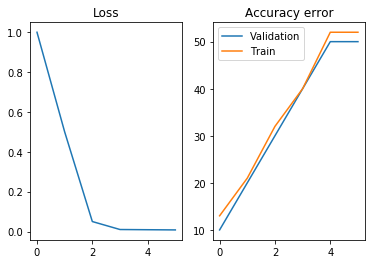

In [14]:
def plot_history(loss_history, train_acc=False, **kwargs):
        
    fig, ax = plt.subplots(1,2)
    ax[0].plot(loss_history['iter'],loss_history['loss'], **kwargs)
    ax[0].set_title('Loss')

    ax[1].plot(loss_history['iter'],loss_history['dev_acc'], label='Validation', **kwargs)
    if train_acc:
        ax[1].plot(loss_history['iter'],loss_history['train_acc'], label='Train', **kwargs)
    
    ax[1].set_title('Accuracy error')
    ax[1].legend()
    fig.savefig('./loss_history-{}.png'.format(now.strftime("%Y-%m-%d-%H-%M-%S")))

loss_history = {'iter': [0,1,2,3,4,5],
                'loss': [1, .5, .05, .01, .009, .008],
                'dev_acc': [10, 20, 30, 40, 50, 50],
                'train_acc': [13, 21, 32, 40, 52, 52]}

plot_history(loss_history, train_acc=True)
